In [1]:
import copy
import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bumps

import os
import math

from numpy import exp, linspace, random
from scipy.optimize import curve_fit

path = '../data/conductivity'

In [2]:
"""
Loading in the data and meta-data, do not edit unless necessary for os differences.
"""
# sample meta-data
info_path = path + "/Sample_Info.csv"
corrected_path = path + "/Corrected_wtPercents.csv"
sample_info = pd.read_csv(info_path)
corrected_info = pd.read_csv(corrected_path)
names = {}
cps = {}
matrix = {}
solvent_names = {}
target = {}  # target weight fraction of conjugated polymer
actual = {} # corrected weight fraction of conjugated polymer from UV-vis data

for index, row in sample_info.iterrows():
    sam_no = row['Sample']
    names[sam_no] = row['Name']
    cps[sam_no] = row['Conjugated Polymer']
    matrix[sam_no] = row['Commodity Polymer']
    solvent_names[sam_no] = row['Solvent']
    # change this if target fraction is already in wt percent, rather than wt fraction
    target[sam_no] = float(row['Target Fraction'])*100
for index, row in corrected_info.iterrows():
    sam_no = row['Sample']
    # change this if actual fraction is already in wt percent rather than wt fraction
    actual[sam_no] = float(row['average actual wt pct'])

In [3]:
"""
Importing conductivity data
"""
data_path = path + '/conductivity_data.csv'

#importing into dictionary: {sampleno:measurement}
con_data = {}
file = open(data_path, 'r')
the_lines = file.readlines()[2:]
for each in the_lines:
    split_line = each.split(",")
    con_data[split_line[0]] = float(split_line[15][:-1])
print(con_data)

{'e716': 0.0, 'e715': 3.98e-11, 'e714': 0.0, 'e713': 0.0, 'e711': 5.94e-10, 'e710': 3.5e-10, 'e709': 2.12e-10, 'e708': 7.84e-11, 'e707': 1.27e-10, 'e705': 5.36e-10, 'e704': 1.55e-10, 'e703': 2.82e-11, 'e702': 0.0, 'e701': 0.0, 'e611': 1.78e-10, 'e610': 1.07e-10, 'e609': 9.6e-11, 'e608': 0.0, 'e607': 0.0, 'e605': 0.0, 'e604': 0.0, 'e603': 3.15e-10, 'e602': 6.11e-11, 'e601': 0.0, 'e210': 0.0, 'e205': 0.0, 'e108': 9.14e-10, 'e107': 0.0, 'e106': 0.0, 'e105': 1.14e-09, 'e104': 7.75e-10, 'e103': 0.0, 'e102': 0.0, '505': 0.0, '504': 0.0, '408': 1.44e-09, '405': 8.83e-09, '404': 0.0, '403': 0.0, '305': 0.0, '206': 0.0, '203': 0.0, '112': 1.44e-10, '111': 1.35e-10, '107': 5.65e-07, '106': 3.71e-08, '105': 0.0, '104': 0.0, '42': 0.0, '34': 1.9e-10, '33': 6.13e-11, '31': 9.18e-10, '30': 0.0, '27': 3.18e-10, '26': 0.0, '24': 0.0, '20': 0.0, '15': 2.11e-10, '14': 0.0, '13': 0.0, '10': 0.0, '5': 1.18e-10, '4': 1.02e-10}


In [4]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

fraction = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    7.5: 'lime',
    10.0: 'deeppink',
    17.5: 'goldenrod',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'darkorchid'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'darkorchid',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

cp_marks = {
    'RRe-P3HT': 'o',
    'RRa-P3HT': '^',
    'P3DDT': 's',
    'PQT-12': 'D',
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
        fraction[key] = actual[key]
    else:
        frac = target[key]
        fraction[key] = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]

solubility = {}
solubility['Bromobenzene'] = 84.1
solubility['Chloroform'] = 14.1
solubility['Toluene'] = 0.7
solubility['Slow Dry Chloroform'] = 14.1

polarity = {}
polarity['Bromobenzene'] = 5.17
polarity['Chloroform'] = 4.81
polarity['Toluene'] = 2.38
polarity['Slow Dry Chloroform'] = 4.81

figure_path = path +'/figures'
if 'figures' in os.listdir(path):
    print('figures path already exists')
else:
    os.mkdir(figure_path)

In [5]:
con_group = {}
con_group_1 = {}
con_group_2 = {}
old =[]
new =[]
for num in con_data:
    if 'e' in num:
        new.append(num)
    else:
        old.append(num)

for sample in old:
    x = fraction[sample]
    y = con_data[sample]
    if y > 0.000000000001:
        if cps[sample] in con_group_1.keys():
            a=1
        else:
            con_group_1[cps[sample]]= {}
       
        if solvent_names[sample] in con_group_1[cps[sample]].keys():
            a =1
        else:
            con_group_1[cps[sample]][solvent_names[sample]] = {}
        
        if target[sample] in con_group_1[cps[sample]][solvent_names[sample]].keys():
            con_group_1[cps[sample]][solvent_names[sample]][target[sample]].append([x,y])
        else:
            con_group_1[cps[sample]][solvent_names[sample]][target[sample]] =[[x,y]]

for polymer in con_group_1:
    for solvent in con_group_1[polymer]:  
        for targ in con_group_1[polymer][solvent]:
            x = np.average([item[0] for item in con_group_1[polymer][solvent][targ]])
            dx = np.std([item[0] for item in con_group_1[polymer][solvent][targ]])
            y = np.average([item[1] for item in con_group_1[polymer][solvent][targ]])
            dy = np.std([item[1] for item in con_group_1[polymer][solvent][targ]])
            con_group_1[polymer][solvent][targ] = [x, y, dx, dy]

for sample in new:
    x = fraction[sample]
    y = con_data[sample]
    if y > 0.000000000001:
        if cps[sample] in con_group_2.keys():
            a=1
        else:
            con_group_2[cps[sample]]= {}
       
        if solvent_names[sample] in con_group_2[cps[sample]].keys():
            a =1
        else:
            con_group_2[cps[sample]][solvent_names[sample]] = {}
        
        if target[sample] in con_group_2[cps[sample]][solvent_names[sample]].keys():
            con_group_2[cps[sample]][solvent_names[sample]][target[sample]].append([x,y])
        else:
            con_group_2[cps[sample]][solvent_names[sample]][target[sample]] =[[x,y]]

for polymer in con_group_2:
    for solvent in con_group_2[polymer]:  
        for targ in con_group_2[polymer][solvent]:
            x = np.average([item[0] for item in con_group_2[polymer][solvent][targ]])
            dx = np.std([item[0] for item in con_group_2[polymer][solvent][targ]])
            y = np.average([item[1] for item in con_group_2[polymer][solvent][targ]])
            dy = np.std([item[1] for item in con_group_2[polymer][solvent][targ]])
            con_group_2[polymer][solvent][targ] = [x, y, dx, dy]

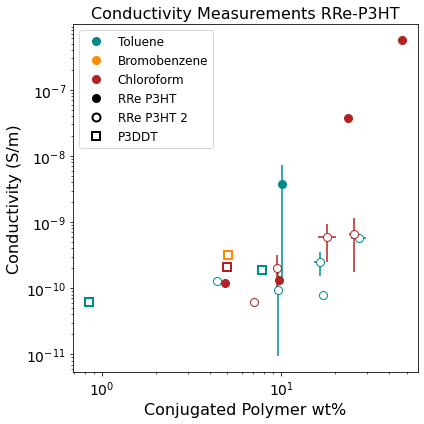

In [6]:
name_of_figure = 'conductivity of all RRe-P3HT'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))

polymer = 'P3DDT'
dict1 = con_group_1
for solvent in dict1[polymer]:
    for targ in dict1[polymer][solvent]:
        x = dict1[polymer][solvent][targ][0]
        xerr = dict1[polymer][solvent][targ][2]
        y = dict1[polymer][solvent][targ][1]
        yerr = dict1[polymer][solvent][targ][3]
        plt.errorbar(x, y, xerr= xerr, yerr= yerr, fmt='s', c = temp_solvent_colors[solvent],mfc = 'white', mew =2, ms=8)
    plt.errorbar([-10], [-10],fmt='o', label= solvent, c = temp_solvent_colors[solvent], ms=8)

polymer = 'RRe-P3HT'
dict1 = con_group_1
for solvent in dict1[polymer]:
    for targ in dict1[polymer][solvent]:
        x = dict1[polymer][solvent][targ][0]
        xerr = dict1[polymer][solvent][targ][2]
        y = dict1[polymer][solvent][targ][1]
        yerr = dict1[polymer][solvent][targ][3]
        plt.errorbar(x, y, xerr= xerr, yerr= yerr, fmt='o', c = temp_solvent_colors[solvent], ms=8)
    
polymer = 'RRe-P3HT'
dict1 = con_group_2
for solvent in dict1[polymer]:
    for targ in dict1[polymer][solvent]:
        x = dict1[polymer][solvent][targ][0]
        xerr = dict1[polymer][solvent][targ][2]
        y = dict1[polymer][solvent][targ][1]
        yerr = dict1[polymer][solvent][targ][3]
        plt.errorbar(x, y, xerr= xerr, yerr= yerr, fmt='o', c = temp_solvent_colors[solvent],mfc='white',mew=1, ms=8)
plt.errorbar([-10], [-10],fmt='o', label= 'RRe P3HT', c = 'black', ms=8)
plt.errorbar([-10], [-10],fmt='o', label= 'RRe P3HT 2', c = 'black', mfc = 'white', mew =2,ms =8)
plt.errorbar([-10], [-10],fmt='s', label= 'P3DDT', c = 'black', mfc = 'white', mew =2,ms =8)

plt.xlabel('Conjugated Polymer wt%', fontsize=16)
plt.ylabel('Conductivity (S/m)', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xscale('log')
plt.yscale('log')

plt.title('Conductivity Measurements RRe-P3HT',fontsize=16)

plt.legend(fontsize=12,loc='upper left',title=None, title_fontsize=12)# ncol=3)

plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')